# Importing necessary libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import joblib
import pickle

import sklearn
from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_curve
from sklearn.calibration import calibration_curve

import intel_extension_for_tensorflow as itex
import tensorflow as tf
from tensorflow.keras import layers

import logging
logging.basicConfig(level=logging.WARNING)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Loading the dataset

In [4]:
df=pd.read_csv("final(5).csv")
df.dropna(inplace=True)
df.head()
df.shape

(8089744, 18)

In [5]:
x = df.drop("target", axis=1).to_numpy()
y = df["target"].to_numpy()

# Splitting the dataset into test and train in the ratio of 80:20

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Making a function for model evaluation

In [7]:
def model_eval(y_true, y_pred, y_prob, model):
    
    conf_mat = confusion_matrix(y_true, y_pred)
    
    
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)
    
   
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
    
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot confusion matrix
    labels = [f'{name}\n{count}\n{count / len(y_true) * 100:.5f}%' for name, count in zip(['True Negatives', 'False Positives', 'False Negatives', 'True Positives'], conf_mat.ravel())]
    labels = np.array(labels).reshape(2, 2)
    sns.heatmap(conf_mat, annot=labels, fmt='', cmap='Blues', cbar=False, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'], ax=ax1)
    ax1.set_title('Confusion Matrix')
    
    # Plot ROC curve
    ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Receiver Operating Characteristic (ROC)')
    ax2.legend(loc='lower right')
    
    # Plot Precision-Recall curve
    ax3.plot(recall, precision, color='purple', lw=2, label=f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
    ax3.set_xlim([0.0, 1.0])
    ax3.set_ylim([0.0, 1.05])
    ax3.set_xlabel('Recall')
    ax3.set_ylabel('Precision')
    ax3.set_title('Precision-Recall Curve')
    ax3.legend(loc='lower left')
    
    plt.tight_layout()
    plt.show()
    
    # Plot Calibration curve
    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve', linestyle='-')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Curve')
    plt.legend()
    plt.grid()
    plt.show()
    
    print(f"Testing accuracy of {model}: {accuracy_score(y_true, y_pred)}")
    print(f"Testing f1-score {model}: {f1_score(y_true, y_pred)}")


## Implementing different models

In [8]:
model_training_start = time.time()

## Logistic regression

In [9]:
start_time_lr= time.time()
lr = LogisticRegression(penalty='l2',solver='liblinear')
lr.fit(x_train, y_train)
end_time_lr = time.time()
elapsed_time_lr = end_time_lr - start_time_lr
print("Time taken for training of logistic regression is :-",elapsed_time_lr)

Time taken for training of logistic regression is :- 252.08692860603333


In [10]:
y_pred_lr = lr.predict(x_test)
y_prob_lr = lr.predict_proba(x_test)[:, 1]

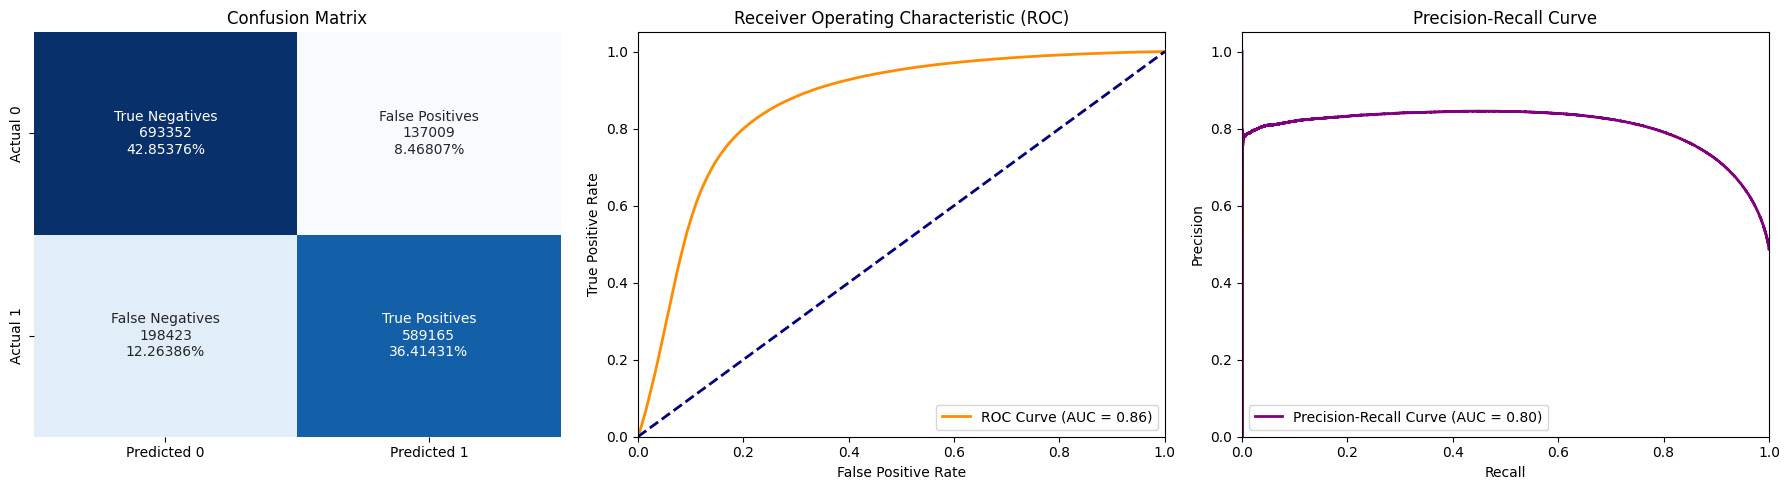

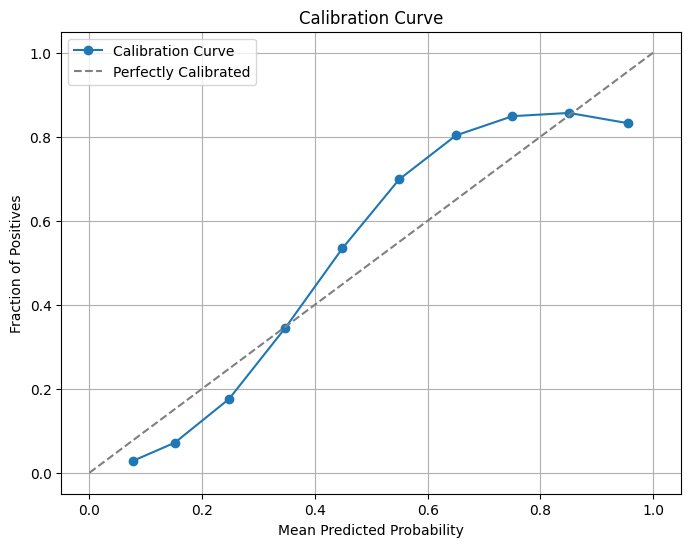

Testing accuracy of linear regression: 0.7926807334470988
Testing f1-score linear regression: 0.7784116657704447


In [11]:
model_eval(y_test, y_pred_lr, y_prob_lr, model="linear regression")

## XG Boost

In [12]:
start_time_XG= time.time()
xgb = XGBClassifier()
xgb.fit(x_train, y_train)
end_time_XG= time.time()
elapsed_time_XG = end_time_XG - start_time_XG
print(elapsed_time_XG)
print("Time taken for training of XG boost is :-",elapsed_time_XG)

175.0657341480255
Time taken for training of XG boost is :- 175.0657341480255


In [13]:
y_pred_xgb = xgb.predict(x_test)
y_prob_xgb = xgb.predict_proba(x_test)[:, 1]

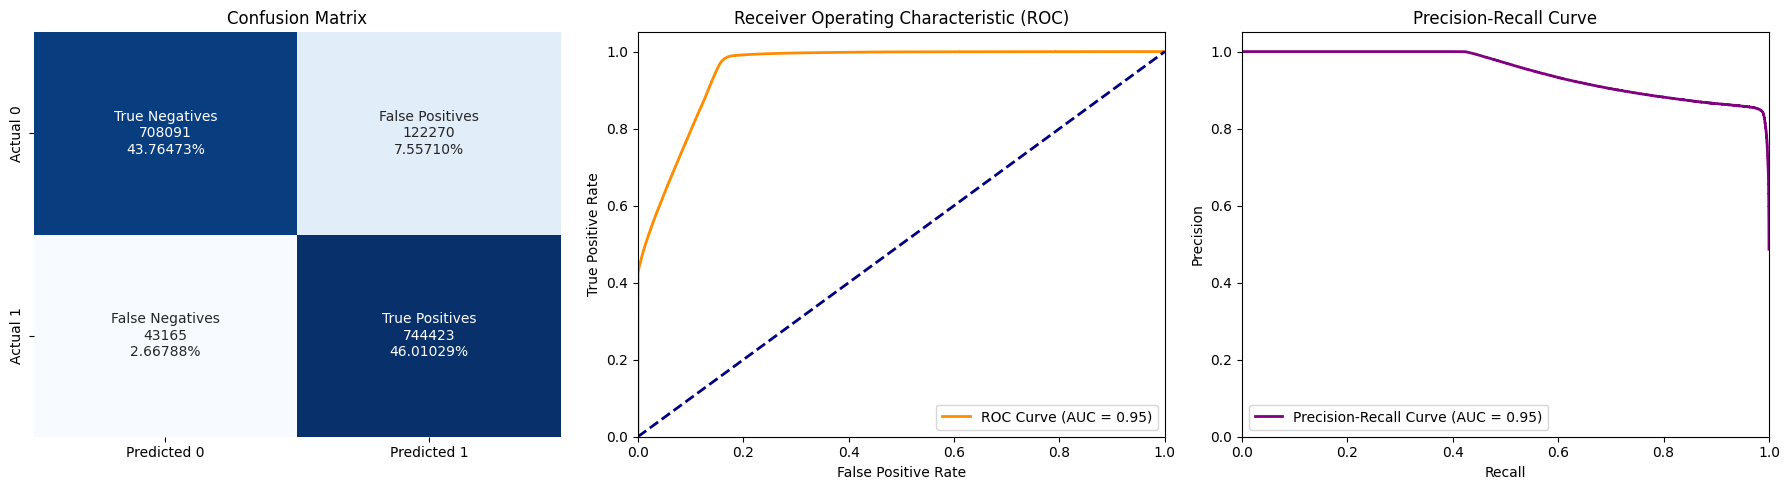

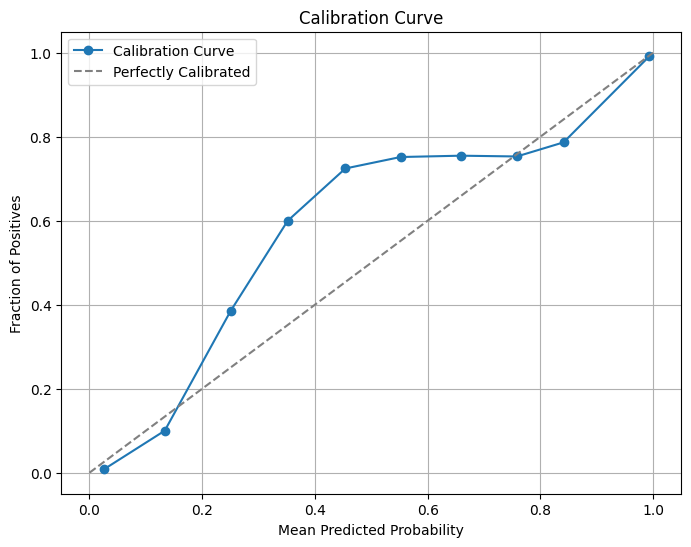

Testing accuracy of XG Boost: 0.8977501763034558
Testing f1-score XG Boost: 0.8999958290036577


In [14]:
model_eval(y_test, y_pred_xgb, y_prob_xgb, model="XG Boost")

## Random forest classifier

In [15]:
start_time_rf= time.time()
rf = RandomForestClassifier(n_estimators=60,random_state=42)
rf.fit(x_train, y_train)
end_time_rf= time.time()
elapsed_time_rf = end_time_rf - start_time_rf
print("Time taken for training of Random forrest is :-",elapsed_time_rf)

Time taken for training of Random forrest is :- 226.2869369983673


In [16]:
y_pred_rf = rf.predict(x_test)
y_prob_rf = rf.predict_proba(x_test)[:, 1]
y_prob_rf = np.clip(y_prob_rf, 0, 1)

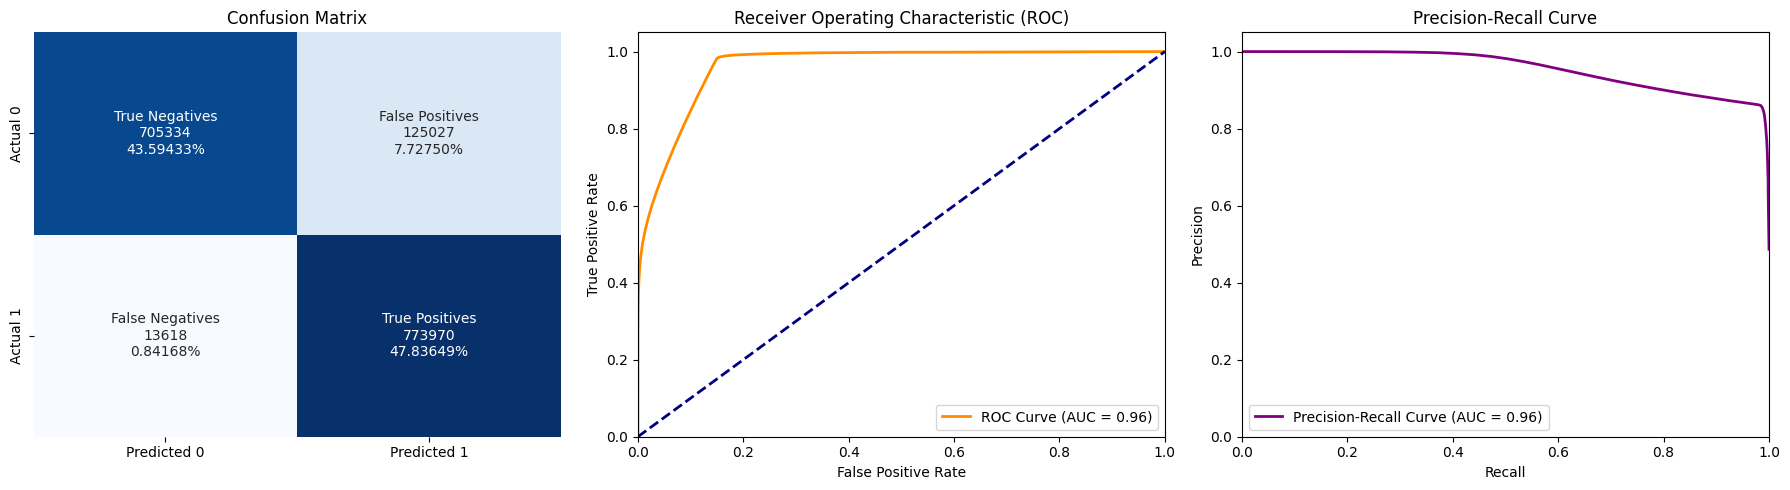

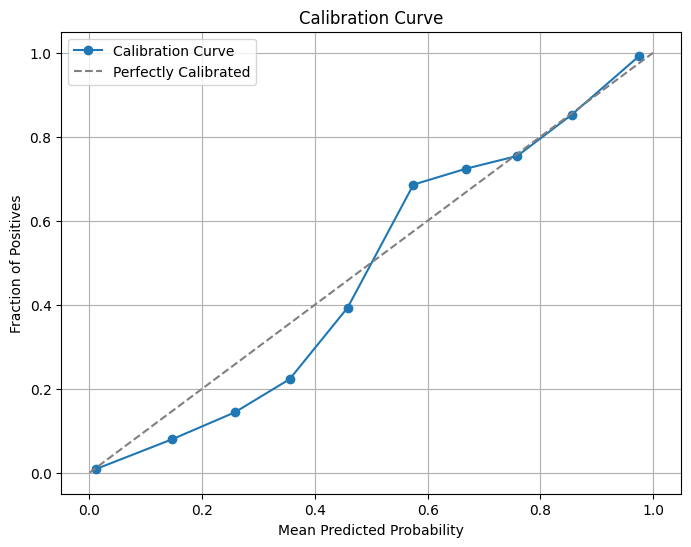

Testing accuracy of Random forest: 0.9143081765865302
Testing f1-score Random forest: 0.9177954268536717


In [17]:
model_eval(y_test, y_pred_rf, y_prob_rf, model="Random forest")

## DNN

In [18]:
start_time_DNN= time.time()
model = tf.keras.Sequential()
model.add(layers.InputLayer(input_shape=(17,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test))

end_time_DNN= time.time()
elapsed_time_DNN = end_time_DNN - start_time_DNN
print("Time taken for training of DNN is :-",elapsed_time_DNN)

Epoch 1/10
101122/101122 [==============================] - 260s 3ms/step - loss: 0.4505 - accuracy: 0.8119 - val_loss: 0.4024 - val_accuracy: 0.8383
Epoch 2/10
101122/101122 [==============================] - 256s 3ms/step - loss: 0.3998 - accuracy: 0.8369 - val_loss: 0.3961 - val_accuracy: 0.8393
Epoch 3/10
101122/101122 [==============================] - 251s 2ms/step - loss: 0.3912 - accuracy: 0.8414 - val_loss: 0.3859 - val_accuracy: 0.8486
Epoch 4/10
101122/101122 [==============================] - 246s 2ms/step - loss: 0.3874 - accuracy: 0.8437 - val_loss: 0.3857 - val_accuracy: 0.8420
Epoch 5/10
101122/101122 [==============================] - 241s 2ms/step - loss: 0.3818 - accuracy: 0.8470 - val_loss: 0.3858 - val_accuracy: 0.8413
Epoch 6/10
101122/101122 [==============================] - 242s 2ms/step - loss: 0.3753 - accuracy: 0.8506 - val_loss: 0.3762 - val_accuracy: 0.8539
Epoch 7/10
101122/101122 [==============================] - 238s 2ms/step - loss: 0.3735 - accuracy:

In [19]:
y_prob_dnn = model.predict(x_test)
y_pred_dnn = np.round(y_prob_dnn)

50561/50561 [==============================] - 35s 685us/step


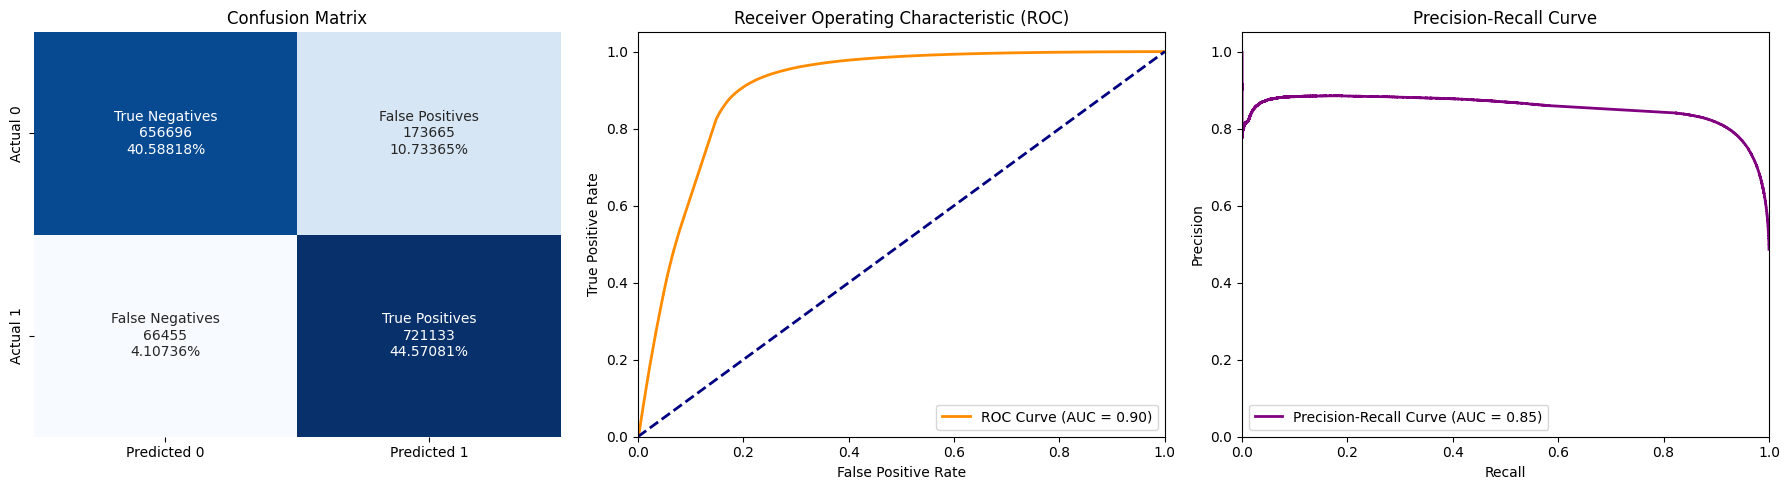

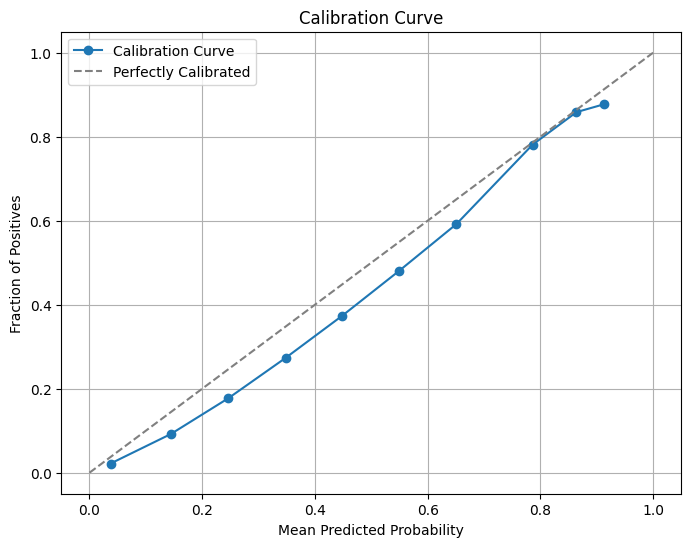

Testing accuracy of DNN: 0.8515898832410663
Testing f1-score DNN: 0.8572741332845137


In [20]:
model_eval(y_test, y_pred_dnn, y_prob_dnn, model="DNN")

-------------------------------------------------------------------------------------------------------------------------------------------

In [21]:
model_training_end = time.time()
elapsed_model_training_time = model_training_start - model_training_end
print("Time taken for all models to trian is :-",elapsed_model_training_time)

Time taken for all models to trian is :- -3217.9459488391876


In [22]:
elapsed_model_training_time = model_training_start - model_training_end

# Evaluating results of all models

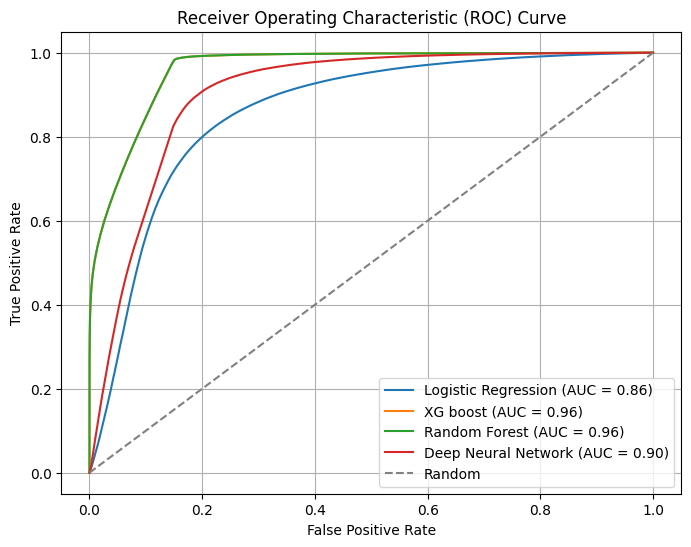

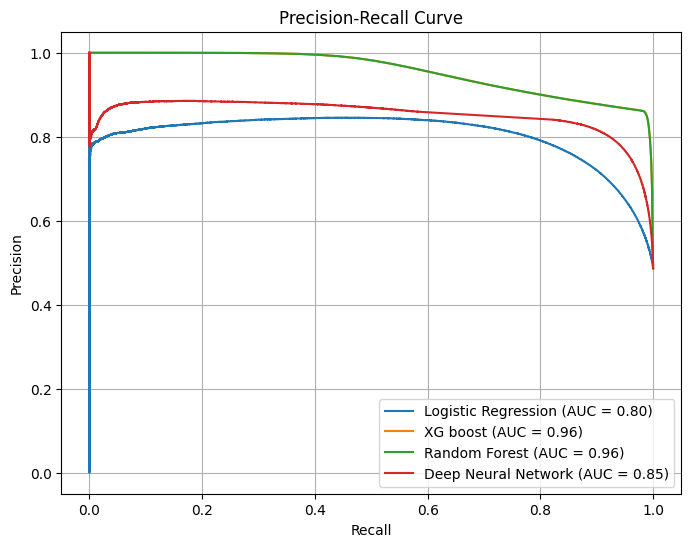

In [23]:
model_results = []

# Define the names of your models
model_names = ["Logistic Regression","XG boost", "Random Forest", "Deep Neural Network"]

# Collect ROC and Precision-Recall metrics from each model
for i, (y_pred, y_prob) in enumerate([(y_pred_lr, y_prob_lr), (y_pred_rf, y_prob_rf), (y_pred_rf, y_prob_rf), (y_pred_dnn, y_prob_dnn)]):
    if isinstance(y_prob, tuple):
        # Unpack the tuple (fpr, tpr)
        fpr, tpr = y_prob
    else:
        # Calculate ROC curve for y_prob
        fpr, tpr, _ = roc_curve(y_test, y_prob)
    
    roc_auc = auc(fpr, tpr)
    
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    
    model_results.append({"fpr": fpr, "tpr": tpr, "roc_auc": roc_auc, "precision": precision, "recall": recall, "pr_auc": pr_auc})

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i, model_result in enumerate(model_results):
    plt.plot(model_result["fpr"], model_result["tpr"], label=f'{model_names[i]} (AUC = {model_result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
for i, model_result in enumerate(model_results):
    plt.plot(model_result["recall"], model_result["precision"], label=f'{model_names[i]} (AUC = {model_result["pr_auc"]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()

plt.show()